<a href="https://colab.research.google.com/github/chungntu/1DCNN-LSTM-ResNet/blob/main/Problem_9_Simply_supported_Bernoulli_problem_under_uniform_load.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== DISPLACEMENTS (U) ===
DOF 1: U = 0.000000e+00
DOF 2: U = -4.166667e-02
DOF 3: U = -5.206716e-04
DOF 4: U = -4.162793e-02
DOF 5: U = -1.040381e-03
DOF 6: U = -4.151302e-02
DOF 7: U = -1.558188e-03
DOF 8: U = -4.132389e-02
DOF 9: U = -2.073177e-03
DOF 10: U = -4.106250e-02
DOF 11: U = -2.584457e-03
DOF 12: U = -4.073079e-02
DOF 13: U = -3.091162e-03
DOF 14: U = -4.033073e-02
DOF 15: U = -3.592449e-03
DOF 16: U = -3.986426e-02
DOF 17: U = -4.087500e-03
DOF 18: U = -3.933333e-02
DOF 19: U = -4.575522e-03
DOF 20: U = -3.873991e-02
DOF 21: U = -5.055745e-03
DOF 22: U = -3.808594e-02
DOF 23: U = -5.527426e-03
DOF 24: U = -3.737337e-02
DOF 25: U = -5.989844e-03
DOF 26: U = -3.660417e-02
DOF 27: U = -6.442302e-03
DOF 28: U = -3.578027e-02
DOF 29: U = -6.884131e-03
DOF 30: U = -3.490365e-02
DOF 31: U = -7.314682e-03
DOF 32: U = -3.397624e-02
DOF 33: U = -7.733333e-03
DOF 34: U = -3.300000e-02
DOF 35: U = -8.139487e-03
DOF 36: U = -3.197689e-02
DOF 37: U = -8.532568e-03
DOF 38: U = -3.090885e

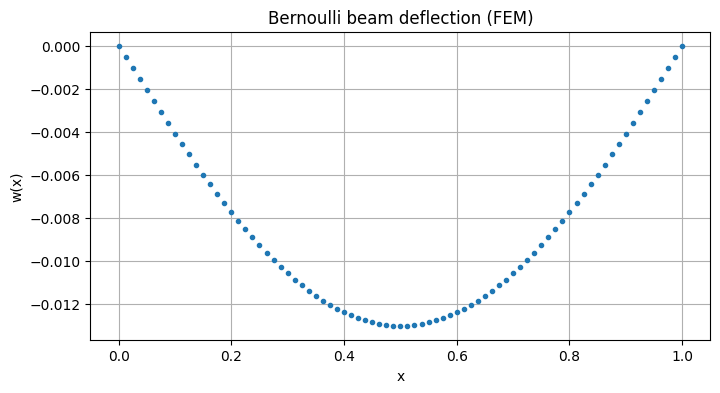


=== MIDSPAN DEFLECTION ===
FEM w(L/2)      = -1.30208333e-02
Exact w(L/2)    = -1.30208333e-02
Relative error  = 2.158e-10


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Bernoulli Beam FEM - Simply supported under uniform load
# (Problem 9) MATLAB -> Python (Google Colab)
# copy & run in 1 cell
# ============================================================

def solution(GDof, prescribedDof, K, F, u_prescribed=None):
    if u_prescribed is None:
        u_prescribed = np.zeros(len(prescribedDof), dtype=float)

    prescribed = np.array([d-1 for d in prescribedDof], dtype=int)  # 0-based
    all_dofs = np.arange(GDof, dtype=int)
    free = np.setdiff1d(all_dofs, prescribed)

    U = np.zeros(GDof, dtype=float)
    U[prescribed] = u_prescribed

    K_ff = K[np.ix_(free, free)]
    K_fp = K[np.ix_(free, prescribed)]
    F_f  = F[free]

    rhs = F_f - K_fp @ U[prescribed]
    U[free] = np.linalg.solve(K_ff, rhs)
    return U


def outputDisplacementsReactions(U, K, GDof, prescribedDof, F):
    R = K @ U - F
    print("=== DISPLACEMENTS (U) ===")
    for i in range(GDof):
        print(f"DOF {i+1}: U = {U[i]:.6e}")

    print("\n=== REACTIONS AT PRESCRIBED DOFs ===")
    for d in prescribedDof:
        print(f"DOF {d}: R = {R[d-1]:.6e}")


def formStiffnessBernoulliBeam(GDof, numberElements, elementNodes, numberNodes, xx, EI, P):
    """
    MATLAB-equivalent:
      k1 = EI/LE^3 * [ 12  6LE  -12  6LE
                      6LE 4LE^2 -6LE 2LE^2
                      -12 -6LE  12  -6LE
                      6LE 2LE^2 -6LE 4LE^2 ]
      f1 = [ P*LE/2
             P*LE^2/12
             P*LE/2
            -P*LE^2/12 ]
    DOFs per node: [w, theta] => global indexing:
      node i: dof_w = 2*i-1, dof_th = 2*i   (MATLAB 1-based)
    """
    F = np.zeros(GDof, dtype=float)
    K = np.zeros((GDof, GDof), dtype=float)

    for e in range(numberElements):
        indice = elementNodes[e, :]  # [i, j] 1-based
        i, j = int(indice[0]), int(indice[1])

        # elementDof = [2*(i-1)+1, 2*(i-1)+2, 2*(j-1)+1, 2*(j-1)+2]
        elementDof = np.array([2*(i-1)+1, 2*(i-1)+2, 2*(j-1)+1, 2*(j-1)+2], dtype=int) - 1

        LE = xx[j-1] - xx[i-1]

        k1 = (EI / (LE**3)) * np.array([
            [ 12.0,   6.0*LE, -12.0,   6.0*LE],
            [  6.0*LE, 4.0*LE**2, -6.0*LE, 2.0*LE**2],
            [-12.0,  -6.0*LE,  12.0,  -6.0*LE],
            [  6.0*LE, 2.0*LE**2, -6.0*LE, 4.0*LE**2],
        ], dtype=float)

        f1 = np.array([
            P*LE/2.0,
            P*LE*LE/12.0,
            P*LE/2.0,
            -P*LE*LE/12.0
        ], dtype=float)

        F[elementDof] += f1
        K[np.ix_(elementDof, elementDof)] += k1

    return K, F


# ============================================================
# Main (equivalent to problem9.m)
# ============================================================

# Material / section
E = 1.0
I = 1.0
EI = E * I

# Mesh
numberElements = 80
nodeCoordinates = np.linspace(0.0, 1.0, numberElements + 1)  # column in MATLAB
xx = nodeCoordinates
L = np.max(nodeCoordinates)
numberNodes = nodeCoordinates.size

# connectivity
elementNodes = np.column_stack([np.arange(1, numberElements+1), np.arange(2, numberElements+2)]).astype(int)

# distributed load
P = -1.0

# DOF
GDof = 2 * numberNodes

# stiffness + force
K, F = formStiffnessBernoulliBeam(GDof, numberElements, elementNodes, numberNodes, xx, EI, P)

# Boundary conditions (MATLAB options)
# - clamped-clamped:
# fixedNodeU = [1, 2*numberElements+1]; fixedNodeV = [2, 2*numberElements+2]
# - simply-supported (as in screenshot):
fixedNodeU = [1, 2*numberElements + 1]  # w(0)=0, w(L)=0
fixedNodeV = []                         # rotations free

prescribedDof = fixedNodeU + fixedNodeV

# Solution
displacements = solution(GDof, prescribedDof, K, F)

# Output displacements/reactions
outputDisplacementsReactions(displacements, K, GDof, prescribedDof, F)

# Plot deflection w(x)
w = displacements[0:GDof:2]  # MATLAB: displacements(1:2:2*numberNodes)
plt.figure(figsize=(8,4))
plt.plot(nodeCoordinates, w, ".")
plt.grid(True)
plt.xlabel("x")
plt.ylabel("w(x)")
plt.title("Bernoulli beam deflection (FEM)")
plt.show()

# Compare midspan deflection with exact (given in figure)
# delta_exact = 5*P*L^4/(384*EI) (note: sign depends on P)
delta_exact = 5.0 * P * (L**4) / (384.0 * EI)
mid_node = numberNodes // 2
delta_fem = w[mid_node]

print("\n=== MIDSPAN DEFLECTION ===")
print(f"FEM w(L/2)      = {delta_fem:.8e}")
print(f"Exact w(L/2)    = {delta_exact:.8e}")
print(f"Relative error  = {abs((delta_fem - delta_exact)/delta_exact):.3e}" if delta_exact != 0 else "Exact is zero")
